# Zillow Project
## Clustering Module
By Michael P. Moran

## Table of contents
1. [Project Planning](#project-planning)
1. [Prepare Environment](#prepare-environment)
1. [Acquisition](#acquisition)
1. [Preparation](#preparation)
1. [Exploration](#exploration)
1. [Modeling](#modeling)

## TODO
- SQL query
    - [X] only include properties with a transaction in 2016 &/or 2017 (along with zestimate error and date of transaction).
- Removing lots
    - [ ] find a ratio between taxlandvalue and lotsizesquarefeet to exclude lots (there are some with 70k taxappraisalvalue and a lotsize of 30-40k square feet
    - [X] fill taxdelinquencyflag with N for the NaNs.
    - [ ] what to do with taxdelinquencyyear? maybe combine the flag with the year to create a variable that reflects how long it has been delinquent and put a 0 for those that are not delinquent
    - [ ] combine calculatedsqft and lotsizesqft???
    - [ ] combine bedroomcnt and bathroomcnt?
    - [ ] encode delinquency column
    - [ ] handle duplicate parcelids
    
### Presentation
- [ ] Topic will be 3 key takeaways from project
    - e.g., I created this really cool function
    - e.g., or garagecnt is determining the poolcnt
- [ ] Explain what a logerror of between 0 and 1 means, between 1 and 2, etc. It is orders of magnitude

## Project Planning <a name="project-planning"></a>

### Goals

### Deliverables

### Data Dictionary & Domain Knowledge

- regionidcounty
    - 3101 --- 6037 (Los Angeles)
    - 1286 --- 6059 (Orange County)
    - 2061 --- 6111 (Ventura County) 

In [1]:
LA = 3101
ORANGE = 1286
VENTURA = 2061

### Hypotheses

1. Low calculatedsqft is correlated with a higher logerror
1. Low lotsizesqft is correlated with a higher logerror
1. Low taxvaluedollarcnt is correlated with a higher logerror
1. Low bedroomcnt is correlated with a higher logerror
    - 2 to 4 bedrooms have higher logerror
1. Low bathroomcnt is correlated with a higher logerror
    - 1 to 3 bathrooms have higher logerror
1. bedroomcnt and bathroomcnt are positively correlated
1. calculatedsqft and taxvaluedollarcnt are positively correlated
    - Yes. There is a 0.6 correlation coefficient
1. lotsizesqft and taxvaluedollarcnt are positively correlated
    - No. Tax value actually goes down with bigger lots (are these lots without houses??)
1. lotsizesqft is not driving logerror because it is really high for condos (I believe it includes the whole development the condo is on) but the logerror is low for them


### Thoughts & Questions

- remove the condominums and planned unit developments?

## Prepare Environment <a name="prepare-environment"></a>

In [2]:
import acquire_zillow
import prepare_zillow
import explore_zillow
import adalib
from importlib import reload

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pd.set_option('display.width', 1000)

**Reload modules to capture changes**

In [3]:
acquire_zillow = reload(acquire_zillow)
prepare_zillow = reload(prepare_zillow)
explore_zillow = reload(explore_zillow)
adalib = reload(adalib)

## Acquisition <a name="acquisition"></a>

In [4]:
df = acquire_zillow.get_zillow_from_csv("zillow_data.csv")

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (56) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


## Preparation <a name="preparation"></a>

### Summarize Data

In [5]:
prepare_zillow.summarize(df)

HEAD
   Unnamed: 0  parcelid         basementsqft          bathroomcnt  \
0           0  11016594                  nan                 2.00   
1           1  14366692                  nan                 3.50   
2           2  12098116                  nan                 3.00   
3           3  12643413                  nan                 2.00   
4           4  14432541                  nan                 2.50   

            bedroomcnt  buildingqualitytypeid    calculatedbathnbr  \
0                 3.00                   4.00                 2.00   
1                 4.00                    nan                 3.50   
2                 2.00                   4.00                 3.00   
3                 2.00                   4.00                 2.00   
4                 4.00                    nan                 2.50   

            decktypeid  finishedfloor1squarefeet  \
0                  nan                       nan   
1                  nan                       nan   
2  

DESCRIPTION
                Unnamed: 0             parcelid         basementsqft  \
count           167,888.00           167,888.00                93.00   
mean             42,210.24        12,995,358.54               695.38   
std              24,641.50         3,016,071.40               583.95   
min                   0.00        10,711,738.00                38.00   
25%              20,985.75        11,548,985.75               280.00   
50%              41,971.50        12,540,601.00               588.00   
75%              62,957.25        14,219,303.00               819.00   
max              90,274.00       167,689,317.00             3,560.00   

               bathroomcnt           bedroomcnt  buildingqualitytypeid  \
count           167,854.00           167,854.00             107,173.00   
mean                  2.29                 3.04                   6.02   
std                   1.00                 1.15                   1.88   
min                   0.00                 

(10554760.42, 26409495.9]     167841
(26409495.9, 42107253.8]           0
(42107253.8, 57805011.7]           0
(57805011.7, 73502769.6]           0
(73502769.6, 89200527.5]           1
(89200527.5, 104898285.4]          4
(104898285.4, 120596043.3]         0
(120596043.3, 136293801.2]         0
(136293801.2, 151991559.1]         0
(151991559.1, 167689317.0]        42
Name: parcelid, dtype: int64


basementsqft:
(34.477000000000004, 390.2]    31
(390.2, 742.4]                 32
(742.4, 1094.6]                14
(1094.6, 1446.8]                7
(1446.8, 1799.0]                5
(1799.0, 2151.2]                2
(2151.2, 2503.4]                0
(2503.4, 2855.6]                0
(2855.6, 3207.8]                1
(3207.8, 3560.0]                1
Name: basementsqft, dtype: int64


bathroomcnt:
(-0.021, 2.0]    100913
(2.0, 4.0]        61224
(4.0, 6.0]         5003
(6.0, 8.0]          617
(8.0, 10.0]          84
(10.0, 12.0]          9
(12.0, 14.0]          1
(14.0, 16.0]          1
(16.0

yardbuildingsqft26:
(10.645000000000001, 147.4]    79
(147.4, 282.8]                 35
(282.8, 418.2]                 19
(418.2, 553.6]                 11
(553.6, 689.0]                  6
(689.0, 824.4]                  1
(824.4, 959.8]                  4
(959.8, 1095.2]                 3
(1095.2, 1230.6]                5
(1230.6, 1366.0]                2
Name: yardbuildingsqft26, dtype: int64


yearbuilt:
(1823.807, 1843.2]        1
(1843.2, 1862.4]          0
(1862.4, 1881.6]          3
(1881.6, 1900.8]        183
(1900.8, 1920.0]       3772
(1920.0, 1939.2]      14536
(1939.2, 1958.4]      40250
(1958.4, 1977.6]      43705
(1977.6, 1996.8]      41424
(1996.8, 2016.0]      22954
Name: yearbuilt, dtype: int64


numberofstories:
1.00    22413
2.00    14808
3.00      945
4.00        2
6.00        1
Name: numberofstories, dtype: int64


fireplaceflag:
1.00    394
Name: fireplaceflag, dtype: int64


structuretaxvaluedollarcnt:
(-11377.747, 1142218.6]     166173
(1142218.6, 2284393.2]   

### Handle Missing Values

Run the first function that returns missing value totals by column: Does the attribute have enough information (i.e. enough non-null values) to be useful? Choose your cutoff and remove columns where there is not enough information available. Document your cutoff and your reasoning.

**Drop certain columns**
        
- 100% or near 100% missing values
    - architecturalstyledesc
    - basementsqft
    - buildingclassdesc
    - decktypeid
    - finishedfloor1squarefeet
    - finishedsquarefeet13
	- finishedsquarefeet15
    - finishedsquarefeet50
    - finishedsquarefeet6
	- fireplacecnt
    - fireplaceflag
    - garagecarcnt
    - garagetotalsqft
    - hashottuborspa
    - numberofstories
	- poolsizesum
    - pooltypeid10
    - pooltypeid2
	- storydesc
    - taxdelinquencyyear (not sure how to impute this one)
    - threequarterbathnbr
    - typeconstructiondesc
	- yardbuildingsqft17
    - yardbuildingsqft26
    
- too difficult to impute
    - regionidneighborhood (almost 50% missing; not sure how to impute this)
    
- inferior information
    - fullbathcnt
        - because bathroomcnt has more fine-grained information; it includes half bathrooms, etc.

- unsure what to do with
    - airconditioningdesc
    - heatingorsystemdesc


**Impute 0 for certain columns**

- hashottuborspa
- poolcnt
- pooltypeid7

**Impute values for certain columns**
- most frequent value
    - buildingqualitytypeid (7)
    - propertyzoningdes (LAR1)
    - regionidcity (12447)
    - regionidzip (?)
    - yearbuilt (1950)
- linear regression
    - lotsizesquarefeet
- constant
    - taxdelinquencyflag ("N")

**Drop rows**
- Those with NaN in columns with only few NaNs (not worth the time to impute)
    - taxvaluedollarcnt
    - landtaxvaluedollarcnt
    - taxamount
    - censustractandblock
    
those with nan in landtaxvaluedollarcnt

### Handle Duplicates

**Drop certain columns**

- Same information
    - calculatedbathnbr
        - because it has 99% of the same values as bathroomcnt
    - finishedsquarefeet12
        - because it has the same information as calculatedfinishedsquarefeet except for 9 rows.
    - structuretaxvaluedollarcnt
        - because it has the same info as taxvaluedollarcnt

In [6]:
(df.parcelid.value_counts() > 1).sum()

2669

### Fix Data Types

**Convert the following columns to categorical type**

- buildingqualitytypeid
- fips
- rawcensustractandblock
- regionidcity
- regionidcounty
- regionidneighborhood
- regionidzip
- unitcnt
- censustractandblock

### Handle Outliers

- Targeting the following columns
    - bathroomcnt
    - bedroomcnt
    - calculatedfinishedsquarefeet
    - structuretaxvaluedollarcnt
    - landtaxvaluedollarcnt
    - lotsizesquarefeet

### Run prepare function to do everything

In [7]:
df = prepare_zillow.prepare_zillow(df)

### Add columns

**add column with abs of logerror**

In [8]:
df["logerror_abs"] = df.logerror.abs()

### Check for missing values again

In [9]:
prepare_zillow.df_missing_vals_by_col(df)

,nmissing,percentage,nempty
Unnamed: 0,0,0.00,0
parcelid,0,0.00,0
bathroomcnt,0,0.00,0
bedroomcnt,0,0.00,0
buildingqualitytypeid,0,0.00,0
calculatedfinishedsquarefeet,0,0.00,0
fips,0,0.00,0
latitude,0,0.00,0
longitude,0,0.00,0
lotsizesquarefeet,0,0.00,0


## Exploration  <a name="exploration"></a>

**Bin logerror**

**by explicit bins**

In [10]:
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)], closed="left")
df["logerror_bin"] = explore_zillow.series_bin_with_labels(df.logerror_abs, bins, (0, 1, 2, 3, 4, 5))

**by quartile**

In [11]:
df["logerror_bin_quart"] = pd.qcut(df.logerror_abs, q=4)

**Create sample of df for exploration**

In [12]:
df_sample = df.sample(n=25_000, random_state=123)

**Create lists holding column names for continuous and categorical variables**

In [13]:
continuous_cols = ["calculatedfinishedsquarefeet",
                "latitude", "longitude", "lotsizesquarefeet",
                "yearbuilt", "taxvaluedollarcnt", "landtaxvaluedollarcnt", "logerror"]

contin_and_cat_cols = ["bathroomcnt", "bedroomcnt", "poolcnt"]

<Figure size 720x720 with 0 Axes>

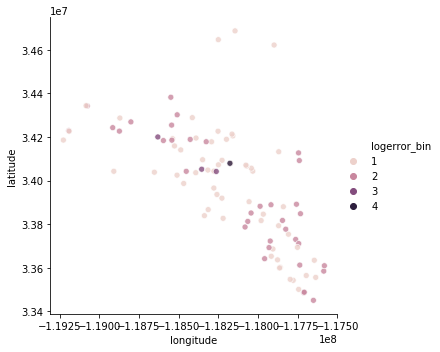

In [14]:
def relplot_num_and_cat(df: pd.DataFrame, x: str, y: str, hue: str) -> pd.DataFrame:
    """
    Write a function that will use seaborn's relplot to plot 2 numeric (ordered) variables
    and 1 categorical variable. It will take, as input, a dataframe, column name indicated
    for each of the following: x, y, & hue.
    """
    plt.figure(figsize=(10, 10))
    sns.relplot(x=x, y=y, hue=hue, data=df, alpha=0.8, legend="full")
    plt.show

relplot_num_and_cat(df_sample[df_sample.logerror_bin != 0].astype({"logerror_bin": int}), "longitude", "latitude", "logerror_bin")

**Conclusions**
- From RelPlot
    - Houses with a logerror > 1 appear to form clusters based on longitude and latitude

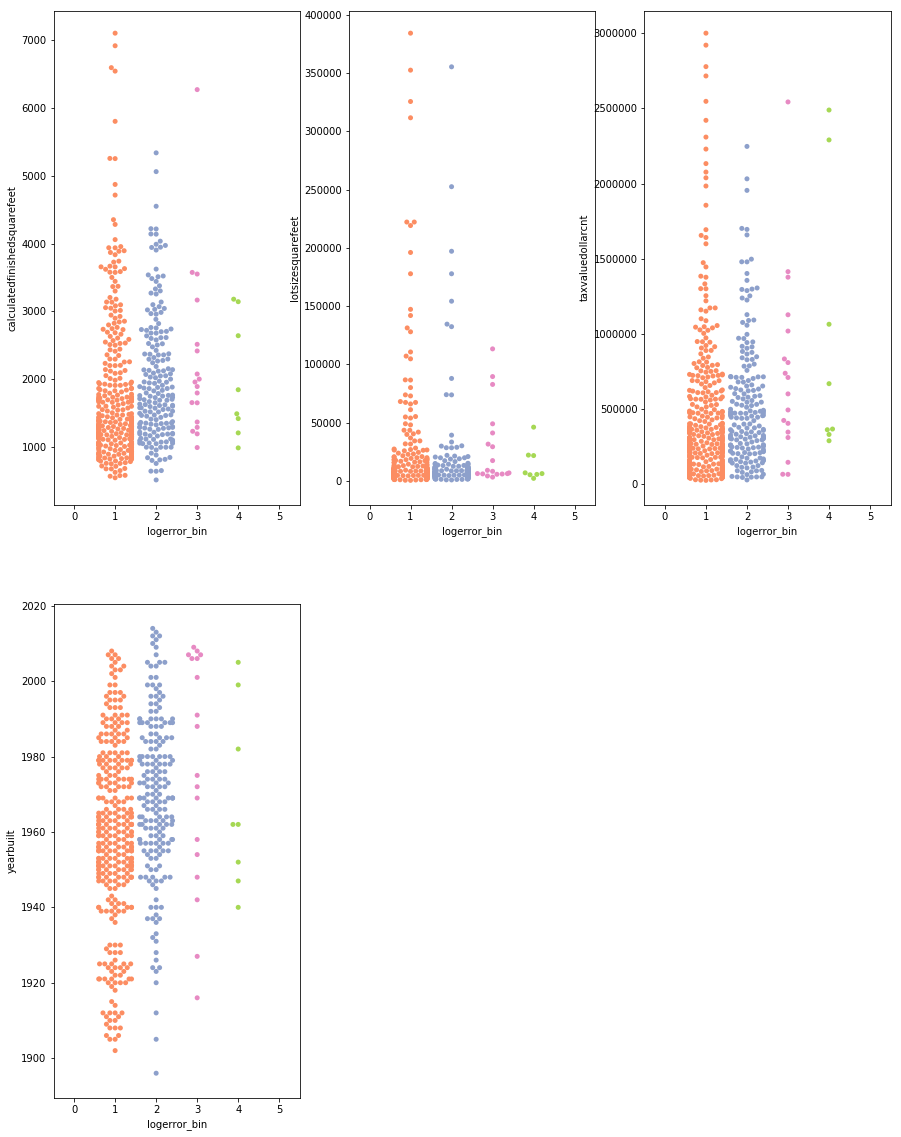

In [15]:
import math

def swarmplot_num_and_cat(df: pd.DataFrame, X: str, Y: list, hue: str=None) -> None:
    """
    Write a function that will take, as input, a dataframe, a categorical column name,
    and a list of numeric column names. It will return a series of subplots: a swarmplot
    for each numeric column. X will be the categorical variable.
    """
    cols = 3
    rows = math.ceil(len(Y) / cols) if len(Y) // cols > 0 else 1
    
    plt.figure(figsize=(15, 20))
    for i, y in enumerate(Y):
        plt.subplot(rows, cols, i + 1)
        sns.swarmplot(x=X, y=y, data=df, hue=hue, palette="Set2")
    plt.plot

swarmplot_num_and_cat(df[df.logerror_bin != 0], "logerror_bin",
                      ["calculatedfinishedsquarefeet", "lotsizesquarefeet", "taxvaluedollarcnt", "yearbuilt"])

**Conclusions**
- logerror in bins 1+ is concentreated among houses with < 2k square feet
- logerror in bins 1+ is concentrated among houses with less than 30k lot size square feet
- logerror in bins 1+ is concentrated among houses with a < $750k tax appraisal value; as the error grows larger, the less expensive the houses are
- logerror in bins 1+ is concentrated among houses built after 1945

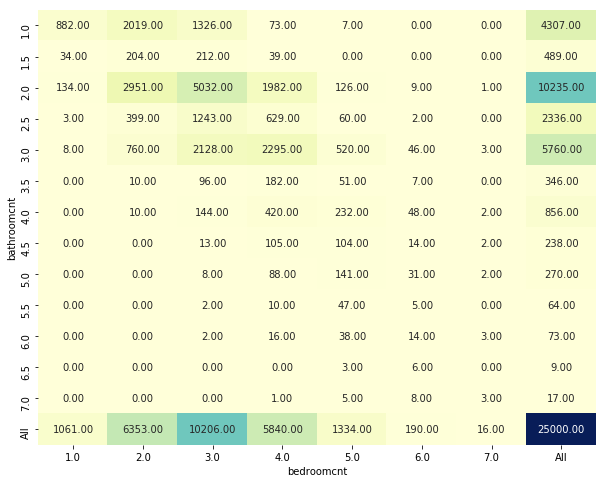

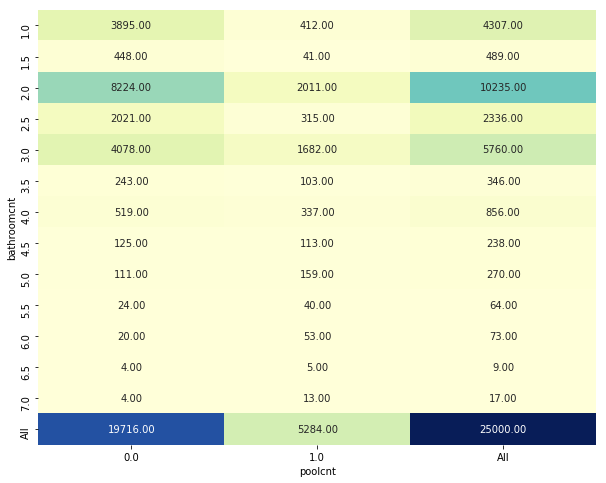

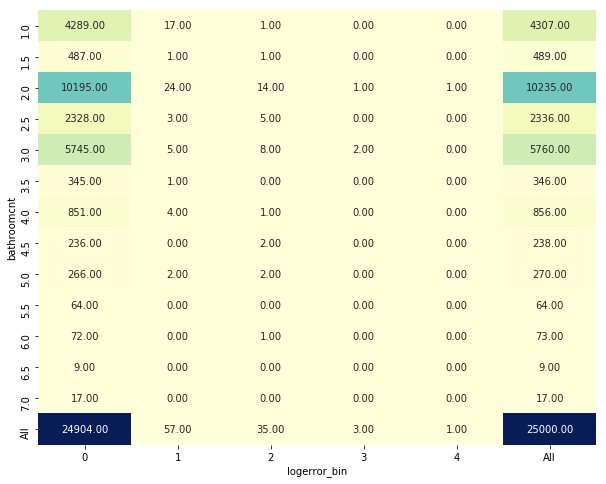

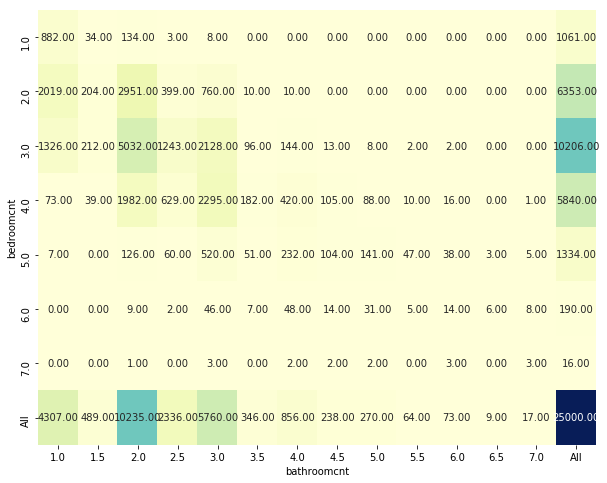

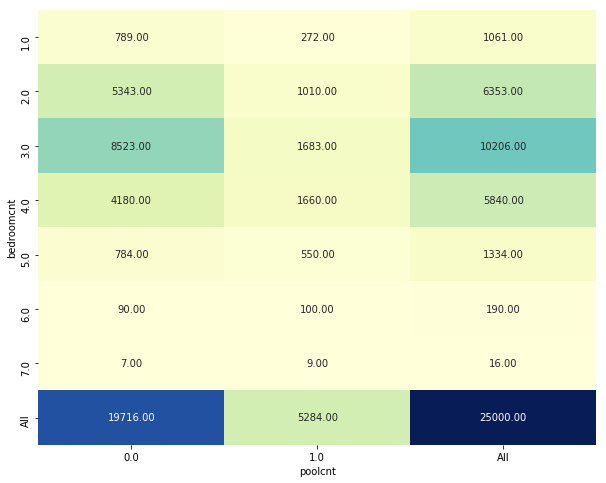

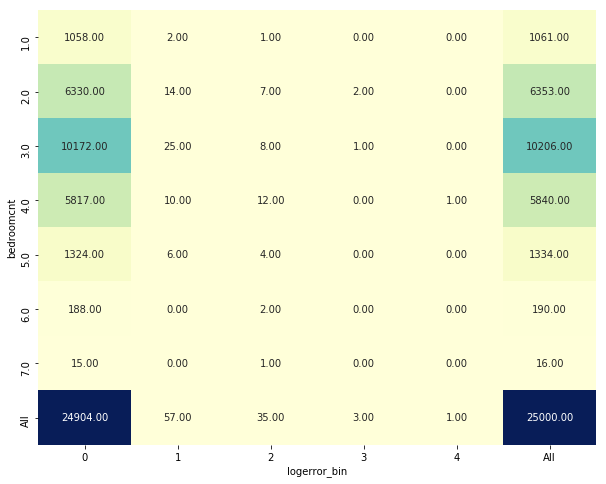

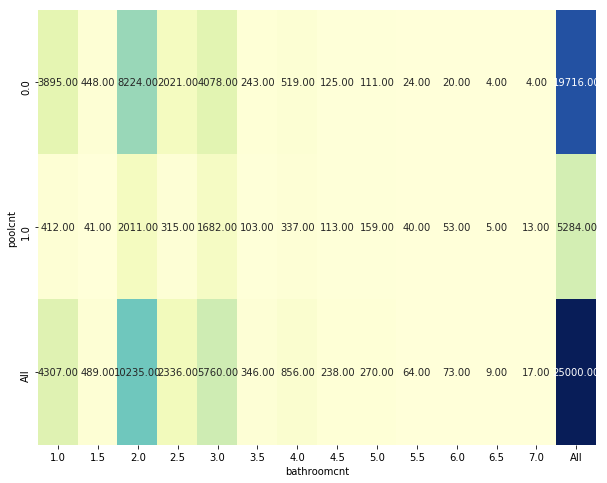

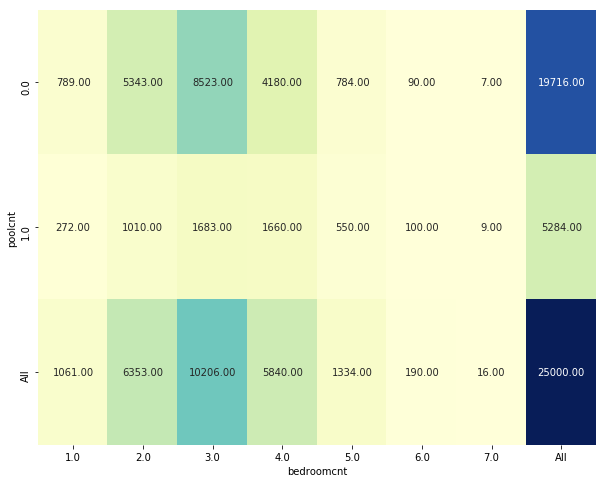

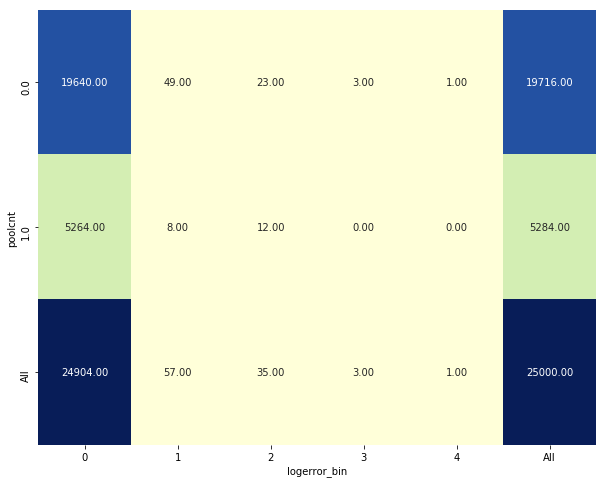

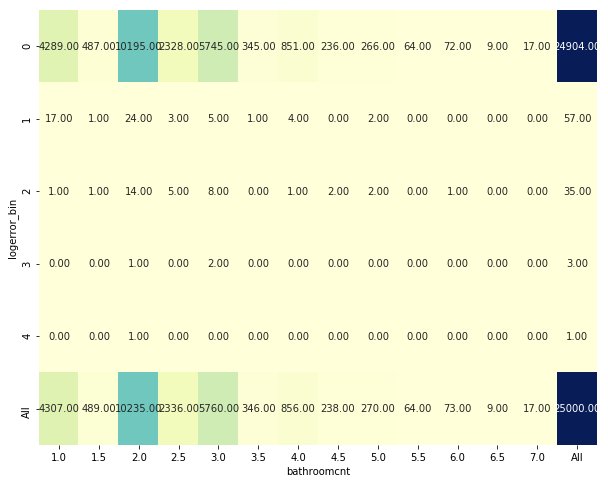

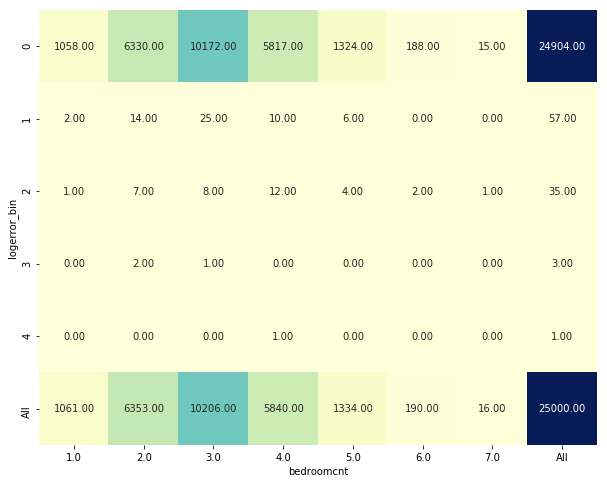

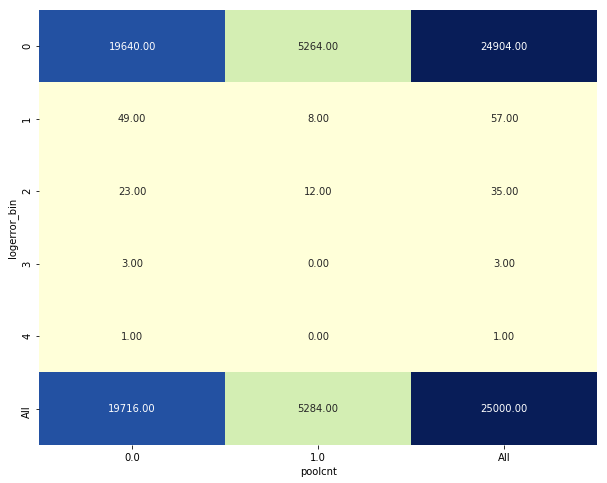

In [16]:
def crosstab_cat(df: pd.DataFrame, cols: list) -> None:
    """
    Write a function that will take a dataframe and a list of categorical columns to plot
    each combination of variables in the chart type of your choice.
    """
    for outer in cols:
        for inner in cols:
            if outer == inner:
                continue
            plt.figure(figsize=(10, 8))
            ct = pd.crosstab(df[outer], df[inner], margins=True)#.apply(lambda r: r/r.sum(), axis=1)
            sns.heatmap(ct, cmap="YlGnBu", annot=True, cbar=False, fmt=".2f")
            #print(pd.crosstab(df[outer], df[inner], margins=True).apply(lambda r: r/r.sum(), axis=1))
            plt.show()
    
crosstab_cat(df_sample, contin_and_cat_cols + ["logerror_bin"])
#pd.crosstab(df.logerror_bin, df.bathroomcnt, margins=True)

### Train-Test Split

### JointPlot

### PairGrid & Heatmap

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/bandwidths.py:20: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/fr

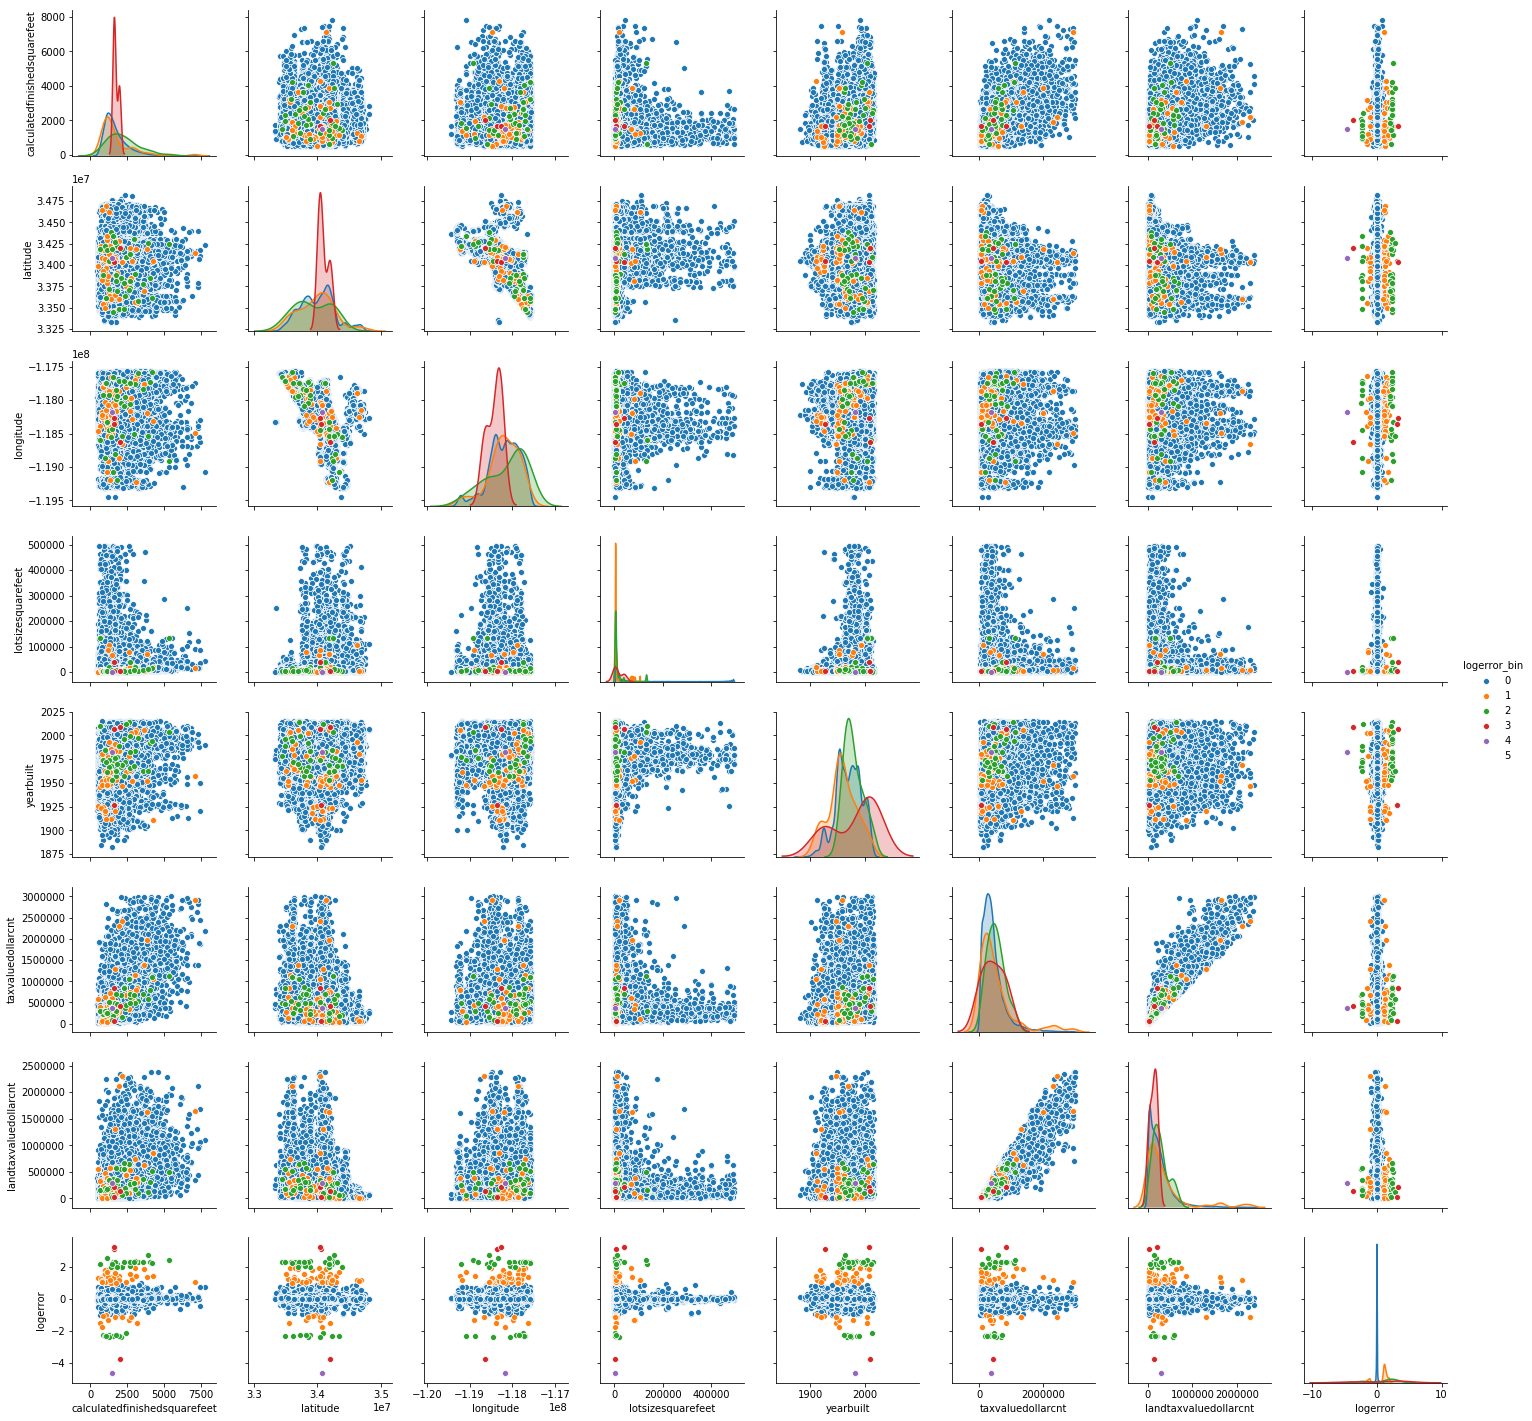

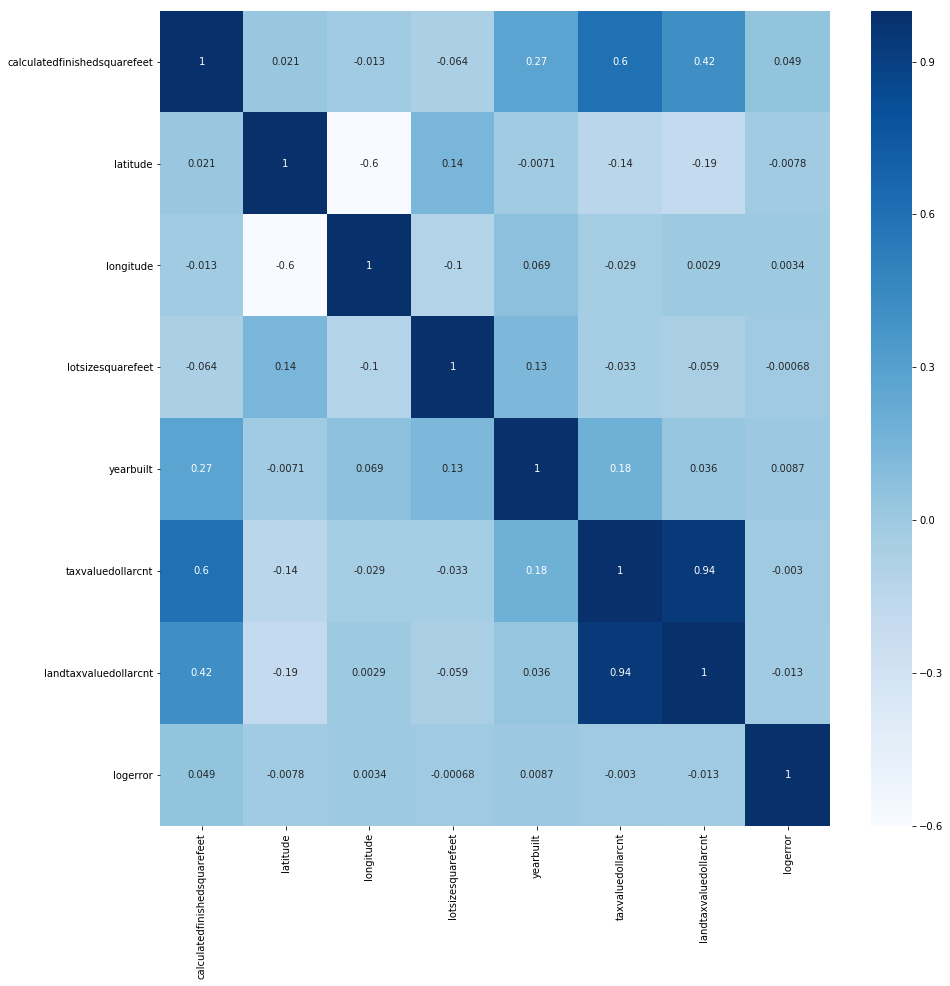

In [17]:
explore_zillow.df_plot_numeric(df_sample, continuous_cols, "logerror_bin")

**Conclusions**

- From PairPlot
    - logerror v. others
        - logerror is worse for homes with a relatively small calculatedsqft and lotsizesqft
        - logerror is worse in the middle of the latitude and longitude values
        - logerror is worse for homes with a relatively low taxvaluedollarcnt, landtaxvaluedollarcnt, and structuretaxvaluedollarcnt
        - worse for homes with fewer bedrooms and bathrooms
    - taxvaluedollarcnt
        - all the variables like this one (landtaxvaluedollarcnt, structuretaxvaluedollarcnt) have similar scatterplots when compared to other variables. They appear to be giving the same information.
    - calculatedfinishedsqft
        - slight correlation with yearbuilt
        - slight correlation with taxvaluedollarcnt (0.6 Pearson R - see HeatMap)
    - bathroomcnt
        - positive correlation between calculatedfinishedsquarefeet
    - bedroomcnt
        - positive correlation between calculatedfinishedsquarefeet
    - latitude
        - houses near the middle of the latitude range have a higher square footage and taxvalue
    - lotsizesquareft
        - as square footage increases, taxvalue appears to decrease (a litle odd?)
        - bedroomcnt and bathroomcnt appear to decrease as well

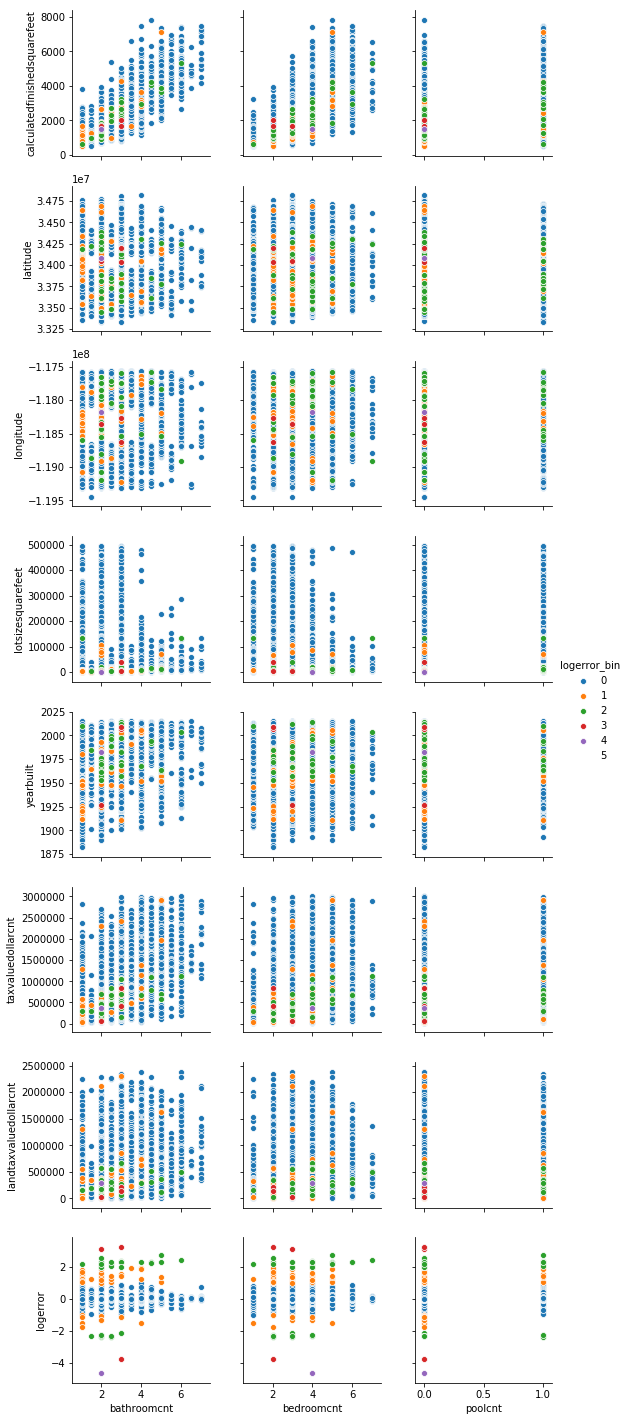

In [18]:
explore_zillow.df_jitter_plot(df_sample, contin_and_cat_cols, continuous_cols, "logerror_bin")

### JitterPlot

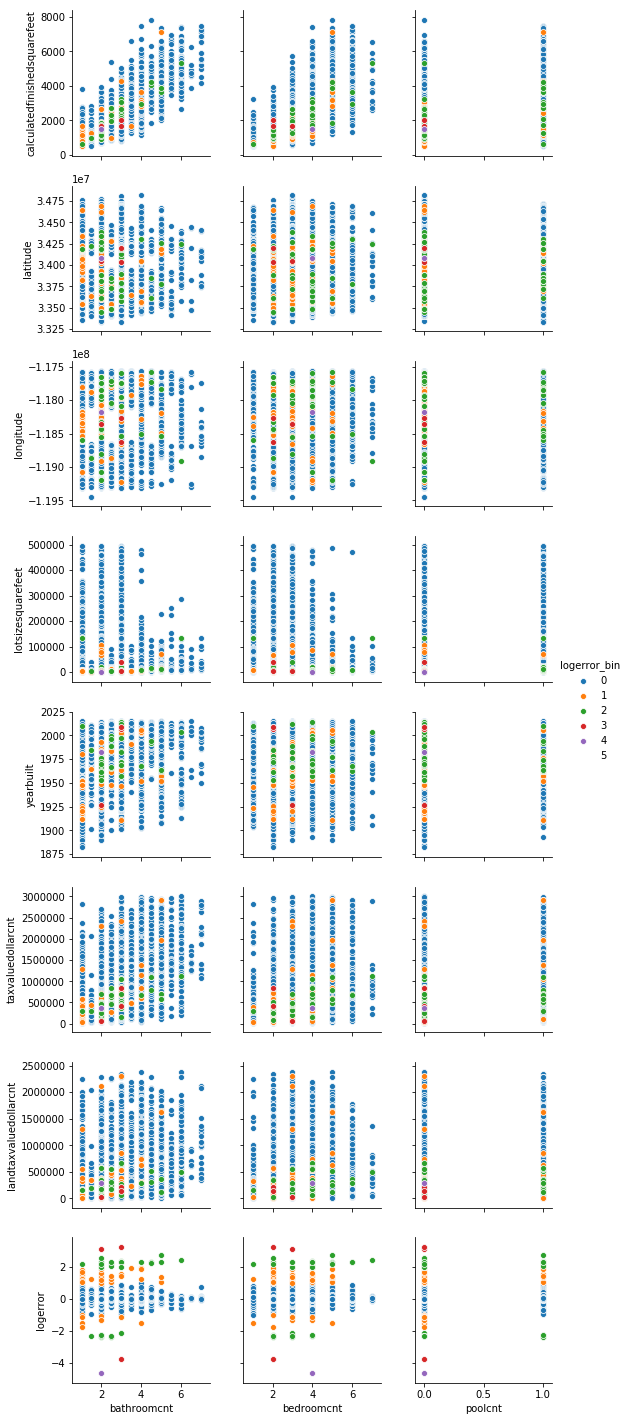

In [19]:
explore_zillow.df_jitter_plot(df_sample, contin_and_cat_cols, continuous_cols, "logerror_bin")

### T-Tests

#### Logerror among conties
**Is logerror significantly different for properties in Los Angeles County vs
Orange County (or Ventura County)?**

**LA v. Orange**
- H0: logerror is not different for properties in LA County v. Orange County
    - Reject the null hypothesis. There is a significant difference.

In [20]:
df.regionidcounty.value_counts()
logerror_la = df[df.regionidcounty == LA].logerror
logerror_orange = df[df.regionidcounty == ORANGE].logerror
logerror_ventura = df[df.regionidcounty == VENTURA].logerror

In [21]:
explore_zillow.series_ttest(logerror_la, logerror_orange)

T-stat: -2.3183508388894336
p-val: 0.020431674767693503


**LA v. Ventura**
- H0: logerror is not different for properties in LA County v. Ventura County
    - Reject the null hypothesis. There is a significant difference.

In [22]:
explore_zillow.series_ttest(logerror_la, logerror_ventura)

T-stat: -2.770043151628885
p-val: 0.005605815436388408


**Orange v. Ventura**
- H0: logerror is not different for properties in Orange County v. Ventura County
    - Fail to reject the null hypothesis.

In [23]:
explore_zillow.series_ttest(logerror_orange, logerror_ventura)

T-stat: -1.2385723237298047
p-val: 0.21550907824670407


Los Angeles median tax appraisal: 322206.0


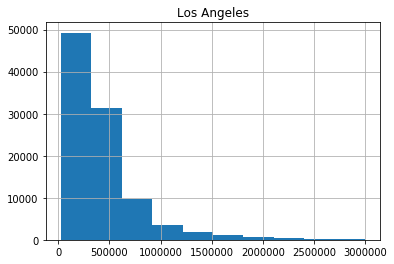

Orange median tax appraisal: 405970.0


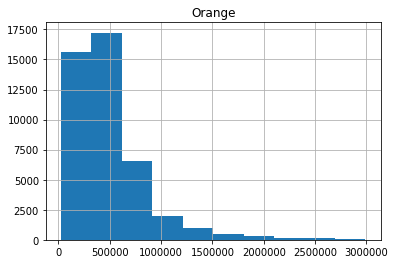

Ventura median tax appraisal: 377578.5


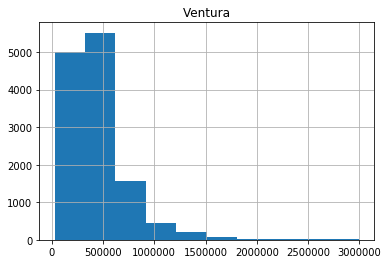

In [24]:
print("Los Angeles median tax appraisal:", df[df.regionidcounty == LA].taxvaluedollarcnt.median())
df[df.regionidcounty == LA].taxvaluedollarcnt.hist()
plt.title("Los Angeles")
plt.show()
print("Orange median tax appraisal:", df[df.regionidcounty == ORANGE].taxvaluedollarcnt.median())
df[df.regionidcounty == ORANGE].taxvaluedollarcnt.hist()
plt.title("Orange")
plt.show()
print("Ventura median tax appraisal:", df[df.regionidcounty == VENTURA].taxvaluedollarcnt.median())
df[df.regionidcounty == VENTURA].taxvaluedollarcnt.hist()
plt.title("Ventura")
plt.show()

**Conclusions**

There are significant differences in logerror when comparing LA County to the other two. However, there is no difference in logerror between Orange and Ventura counties. So, I should include this variable as a feature but bin them based on whether they are in LA County or not.

LA county may be different because it has cheaper homes (where the logerror is worst) than Orange or Ventura County.

#### Logerror based on tax delinquency status

**Is logerror significantly different for properties that are delinquent on their taxes vs those that are not?**
- H0: There is no differnece in logerror for properties that are delinquent v. those that are not
    - Reject the null hypothesis. There is a significant difference in logerror between houses that are delinquent and those that are not.

In [25]:
logerror_delinq = df[df.taxdelinquencyflag == "Y"].logerror
logerror_not_delinq = df[df.taxdelinquencyflag == "N"].logerror

In [26]:
explore_zillow.series_ttest(logerror_delinq, logerror_not_delinq)

T-stat: 6.627089714629757
p-val: 3.434855710886741e-11


**Conclusions**

I will include taxdelinquencyflag as a feature because there are significant differences in logerror for properties that are delinquent v. those that are not. A possible theory is that a tax delinquent status indicates a possible flipped house, which could cause a significant change in the value.

#### Logerror based on yearbuilt

**Is logerror significantly different for properties built prior to 1960 than those built later than 2000?**
- H0: There is no difference in logerror between properties built before 1960 and those built later than 2000
     - Reject the null hypothesis. There is a significant difference.

In [27]:
logerror_pre1960 = df[df.yearbuilt < 1960].logerror
logerror_post2000 = df[df.yearbuilt > 2000].logerror

In [28]:
explore_zillow.series_ttest(logerror_pre1960, logerror_post2000)

T-stat: -4.52320168201737
p-val: 6.101067068599531e-06


**Conclusions**

I may want to include yearbuilt as a feature and bin it. Or I may want to create separate models based on when the house was built

### Chi2 Tests

Because there are many discrete variables, you can the chi-squared test to test proportions. If you split logerror into quartiles, you can expect the overall probability of falling into a single quartile to be 25%. Now, add another variable, like bedrooms (and you can bin these if you want fewer distinct values) and compare the probabilities of bedrooms with logerror quartiles. See the example in the Classification_Project notebook we reviewed on how to implement chi-squared.

#### bedroomcnt v. logerror

H0: The bins for bedroom count and absolute value of logerror are independent
    - Reject the null hypothesis. There are not independent

**Bin bedroomcnt**

In [29]:
bedroomcnt_bins = pd.IntervalIndex.from_tuples([(0, 2), (2, 4), (4, 6), (6, 100)], closed="right")
# df["bedroomcnt_bin"] = explore_zillow.series_bin_with_labels(df.bedroomcnt, bedroomcnt_bins, ["1-2", "3-4", "5-6", "7+"])
df["bedroomcnt_bin"] = pd.cut(df.bedroomcnt, bins=bedroomcnt_bins)

In [30]:
print(df.bedroomcnt_bin.dtype)
print(df.logerror_bin_quart.dtype)

category
category


In [31]:
explore_zillow.series_chi2_test(df.bedroomcnt_bin, df.logerror_bin_quart)

Chi2: 328.9196783465408
p-val: 1.8873350710990824e-65


**Conclusions**

Bedroom count and logerror are related and have some dependency on each other.

#### bathroomcnt v. logerror

H0: The bins for bathroom count and absolute value of logerror are independent
    - Reject the null hypothesis. There are not independent

**Bin bathroomcnt**

In [32]:
bathroomcnt_bins = pd.IntervalIndex.from_tuples([(0, 2), (2, 4), (4, 6), (6, 8), (8, 100)], closed="right")
# df["bedroomcnt_bin"] = explore_zillow.series_bin_with_labels(df.bedroomcnt, bedroomcnt_bins, )
df["bathroomcnt_bin"] = pd.cut(df.bathroomcnt, bins=bathroomcnt_bins)

In [33]:
explore_zillow.series_chi2_test(df.bathroomcnt_bin, df.logerror_bin_quart)

Chi2: 710.7766554475364
p-val: 3.333598073066784e-147


**Conclusions**

Bathroom count and logerror are related and have some dependency on each other, and it's higher than for bedroom count

### Clustering

#### logerror_abs alone

**Elbow Method**

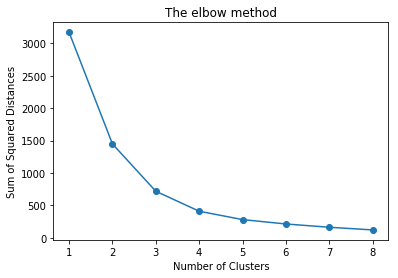

In [34]:
explore_zillow.kmeans_elbow(df[["logerror_abs"]], 8, random_state=123)

In [35]:
df['cluster_target'], labels, interia = explore_zillow.kmeans_fit_and_predict(df[["logerror_abs"]], n_clusters=4, random_state=123)

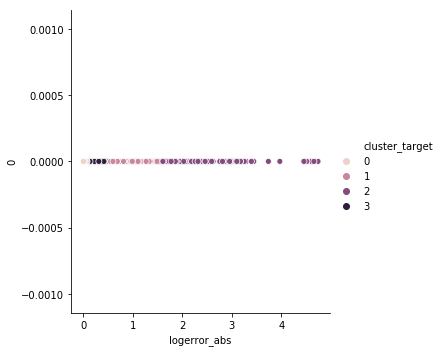

In [36]:
sns.relplot(data=df, x='logerror_abs', y=0, hue='cluster_target', legend="full")
plt.show()

**latitude and longitude**

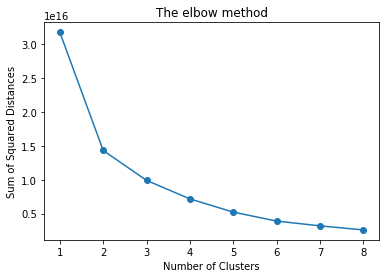

In [37]:
explore_zillow.kmeans_elbow(df[["latitude", "longitude"]], 8, random_state=123)

In [38]:
df['latlong_cluster'], labels, interia = explore_zillow.kmeans_fit_and_predict(df[["latitude", "longitude"]], n_clusters=4, random_state=123)

<Figure size 1080x1080 with 0 Axes>

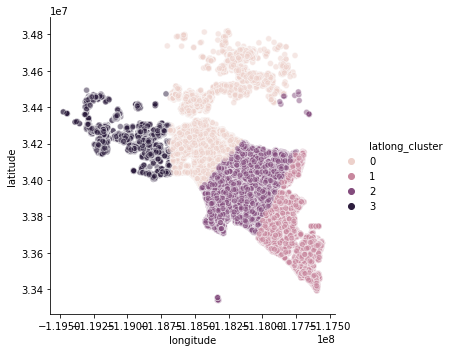

In [39]:
plt.figure(figsize=(15, 15))
sns.relplot(data=df, x='longitude', y="latitude", legend="full", hue='latlong_cluster', alpha=0.5)
plt.show()

In [40]:
df.latlong_cluster.value_counts()

2    56067
0    44433
1    40889
3    13440
Name: latlong_cluster, dtype: int64

In [41]:
pd.get_dummies(df.latlong_cluster, prefix="latlong_cluster")

,latlong_cluster_0,latlong_cluster_1,latlong_cluster_2,latlong_cluster_3
0,1,0,0,0
2,0,0,1,0
3,0,0,1,0
4,0,1,0,0
5,0,0,1,0
6,0,0,1,0
7,0,0,0,1
8,0,1,0,0
9,0,1,0,0
10,1,0,0,0


### More T-tests

#### Is logerror different among the latitude/longitude clusters?

**cluster0 v. not cluster0**

H0: There is not difference in logerror between those houses in cluster0 and those not in cluster0
    - Reject the null hypothesis. There is a significant difference.

In [42]:
explore_zillow.series_ttest(df[df.latlong_cluster == 0].logerror, 
                           df[df.latlong_cluster != 0].logerror)

T-stat: -3.700430999345396
p-val: 0.00021530807427550013


**cluster1 v. not cluster1**

H0: There is no difference in logerror between those houses in cluster1 and those not in cluster1
    - Reject the null hypothesis. There is a significant difference

In [43]:
explore_zillow.series_ttest(df[df.latlong_cluster == 1].logerror, 
                           df[df.latlong_cluster != 1].logerror)

T-stat: 2.525726339707621
p-val: 0.011546927043070618


**cluster2 v. not cluster2**

H0: There is no difference in logerror between those houses in cluster2 and those not in cluster2
    - Fail to reject the null hypothesis.

In [44]:
explore_zillow.series_ttest(df[df.latlong_cluster == 2].logerror, 
                           df[df.latlong_cluster != 2].logerror)

T-stat: -0.7997377249739435
p-val: 0.42386399778590644


**cluster3 v. not cluster3**

H0: There is no difference in logerror between those houses in cluster3 and those not in cluster3
    - Reject the null hypothesis. There is a significant difference.

In [45]:
explore_zillow.series_ttest(df[df.latlong_cluster == 3].logerror, 
                           df[df.latlong_cluster != 3].logerror)

T-stat: 3.3556613667259905
p-val: 0.0007919446936573266


### Summarize Conclusions

## Modeling <a name="modeling"></a>

### Feature Engineering & Selection

**FEATURES**
- [ ] **standardize all dependent variables, including binned ones (have bins be 0.1, 0.2, 0.3, etc)
- regionidcounty
    - [X] Create dummy variable of is_la_county where 1 is yes and 0 is no.
- taxdelinquencyflag
- yearbuilt
    - [X] Create a new variable that reflects the age of the house from 2017.
    - [X] bin the houses by 20 year intervals
- bedroomcnt + bathroomcnt
    - [X] combine bedroomcnt and bathroomcnt and bin them
- calculatedfinishedsqft + taxvaluedollarcnt
    - [ ] combine these


#### Create is_la_county variable

In [46]:
def zillow_create_in_la_county(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.loc[out.regionidcounty != LA, "in_la_county"] = 0
    out.loc[out.regionidcounty == LA, "in_la_county"] = 1
    return out

df = zillow_create_in_la_county(df)

In [47]:
df.in_la_county.value_counts()

1.00    98433
0.00    56396
Name: in_la_county, dtype: int64

#### Create age variable

In [48]:
df["age"] = 2017 - df.yearbuilt

In [49]:
df.age.value_counts(bins=10, dropna=False)

(55.4, 69.0]      36187
(28.2, 41.8]      31348
(41.8, 55.4]      30488
(14.6, 28.2]      21927
(0.863, 14.6]     13214
(69.0, 82.6]      10414
(82.6, 96.2]       8396
(96.2, 109.8]      2268
(109.8, 123.4]      534
(123.4, 137.0]       53
Name: age, dtype: int64

In [50]:
age_bins = pd.IntervalIndex.from_tuples([(0, 20), (20, 40), (40, 60), (60, 80), (80, 100), (100, 500)], closed="left")
df["age_bin"] = explore_zillow.series_bin_with_labels(df.age, age_bins, (0, 2, 4, 6, 8, 10))


In [51]:
df.age_bin.value_counts(dropna=False)

4     43175
2     41184
6     37498
0     20366
8     10373
10     2233
Name: age_bin, dtype: int64

#### Create bedbathcnt

In [52]:
df["bedbathcnt"] = df.bedroomcnt + df.bathroomcnt

**Bin bedbathcnt**

In [53]:
bedbathcnt_bins = pd.IntervalIndex.from_tuples([(0, 4), (4, 8), (8, 12), (12, 16)])
df["bedbathcnt_bin"] = explore_zillow.series_bin_with_labels(df.bedbathcnt, bedbathcnt_bins, (0, 4, 8, 12))

In [54]:
df.bedbathcnt_bin.value_counts(dropna=False)

4     101575
0      46809
8       6333
12       112
Name: bedbathcnt_bin, dtype: int64

#### Create tax_value_per_sqft

In [55]:
df["tax_value_per_sqft"] = df.taxvaluedollarcnt / df.calculatedfinishedsquarefeet

In [56]:
df.tax_value_per_sqft.value_counts(bins=6, dropna=False)

(7.8469999999999995, 547.742]    147635
(547.742, 1084.416]                6715
(1084.416, 1621.091]                389
(1621.091, 2157.765]                 67
(2157.765, 2694.44]                  16
(2694.44, 3231.114]                   7
Name: tax_value_per_sqft, dtype: int64

#### Encode taxdelinquencyflag

In [57]:
from sklearn.preprocessing import LabelEncoder
def zillow_taxdelinquencyflag_encode(series: pd.Series) -> tuple:
    encoder = LabelEncoder()
    encoder.fit(series)
    return encoder.transform(series), encoder

In [58]:
df["taxdelinquencyflag_encode"], taxdelinq_encoder = zillow_taxdelinquencyflag_encode(df.taxdelinquencyflag)


In [59]:
df.taxdelinquencyflag_encode.value_counts(dropna=False)

0    150744
1      4085
Name: taxdelinquencyflag_encode, dtype: int64

In [60]:
taxdelinq_encoder.classes_

array(['N', 'Y'], dtype=object)

In [61]:
pd.get_dummies(df.latlong_cluster, prefix="latlong_cluster")

,latlong_cluster_0,latlong_cluster_1,latlong_cluster_2,latlong_cluster_3
0,1,0,0,0
2,0,0,1,0
3,0,0,1,0
4,0,1,0,0
5,0,0,1,0
6,0,0,1,0
7,0,0,0,1
8,0,1,0,0
9,0,1,0,0
10,1,0,0,0


In [62]:
# convert to int type so the MinMaxScaler works
df = df.astype({"age_bin": int, "bedbathcnt_bin": int, "tax_value_per_sqft": int})

### Split into Train and Test

#### Standardize Variables

### Train & Test Model

#### Few variable Linear Regression

In [63]:
ds_few = adalib.DataSet()
ds_few.df = df.copy()
ds_few.xcols = ["yearbuilt", "bathroomcnt", "bedroomcnt", "taxvaluedollarcnt", "calculatedfinishedsquarefeet", ]
ds_few.ycol = "logerror_abs"

In [64]:
ds_few.X_train, ds_few.X_test, ds_few.y_train, ds_few.y_test = train_test_split(ds_few.df[ds_few.xcols], ds_few.df[[ds_few.ycol]], test_size = .30, random_state = 123)


EQUATION
logerror_abs = 1.52 +
	-0.001 * yearbuilt +
	-0.002 * bathroomcnt +
	-0.007 * bedroomcnt +
	0.000 * taxvaluedollarcnt +
	0.000 * calculatedfinishedsquarefeet
--------------------------------------------------
TRAIN
Univariate Linear Regression Model Evaluation
	Mean SE: 0.020
	Mean AE: 0.059

	Median AE: 0.040

	1.48% of the variance in logerror_abs can be explained by ['yearbuilt', 'bathroomcnt', 'bedroomcnt', 'taxvaluedollarcnt', 'calculatedfinishedsquarefeet'].

P-VALUE
	Train: 3.2e-260
--------------------------------------------------
TEST
Univariate Linear Regression Model Evaluation
	Mean SE: 0.021
	Mean AE: 0.059

	Median AE: 0.040

	1.38% of the variance in logerror_abs can be explained by ['yearbuilt', 'bathroomcnt', 'bedroomcnt', 'taxvaluedollarcnt', 'calculatedfinishedsquarefeet'].

P-VALUE
	Train: 6.58e-99


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


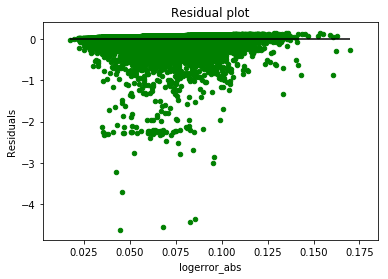

In [65]:
adalib.linreg_model(ds_few.X_train, ds_few.X_test, ds_few.y_train, ds_few.y_test, fit_intercept=True)

#### Linear Regression Model of Non-engineered Features

In [66]:
ds_plain = adalib.DataSet()
ds_plain.df = df.copy()
ds_plain.xcols = ["regionidcounty", "taxdelinquencyflag_encode", "yearbuilt",
        "bathroomcnt", "taxvaluedollarcnt", "calculatedfinishedsquarefeet", "lotsizesquarefeet"]
ds_plain.ycol = "logerror_abs"

In [67]:
ds_plain.X_train, ds_plain.X_test, ds_plain.y_train, ds_plain.y_test = train_test_split(ds_plain.df[ds_plain.xcols], ds_plain.df[[ds_plain.ycol]], test_size = .30, random_state = 123)


EQUATION
logerror_abs = 1.39 +
	0.000 * regionidcounty +
	0.030 * taxdelinquencyflag_encode +
	-0.001 * yearbuilt +
	-0.004 * bathroomcnt +
	0.000 * taxvaluedollarcnt +
	0.000 * calculatedfinishedsquarefeet +
	0.000 * lotsizesquarefeet
--------------------------------------------------
TRAIN
Univariate Linear Regression Model Evaluation
	Mean SE: 0.020
	Mean AE: 0.059

	Median AE: 0.040

	1.50% of the variance in logerror_abs can be explained by ['regionidcounty', 'taxdelinquencyflag_encode', 'yearbuilt', 'bathroomcnt', 'taxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet'].

P-VALUE
	Train: 1.4e-35
--------------------------------------------------
TEST
Univariate Linear Regression Model Evaluation
	Mean SE: 0.021
	Mean AE: 0.059

	Median AE: 0.040

	1.38% of the variance in logerror_abs can be explained by ['regionidcounty', 'taxdelinquencyflag_encode', 'yearbuilt', 'bathroomcnt', 'taxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet'].

P-VALUE
	

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


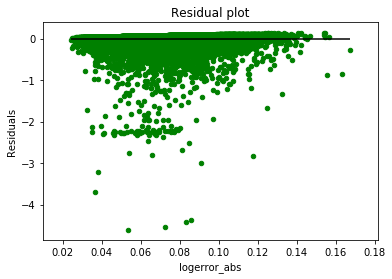

In [68]:
adalib.linreg_model(ds_plain.X_train, ds_plain.X_test, ds_plain.y_train, ds_plain.y_test, fit_intercept=True)

#### Linear Regression Model of Engineered Features

In [69]:
ds = adalib.DataSet()
ds.df = df.copy()
ds.xcols = ["in_la_county", "taxdelinquencyflag_encode", "age_bin",
        "bedbathcnt_bin", "tax_value_per_sqft", "latlong_cluster"]
ds.ycol = "logerror_abs"

ds.X_train, ds.X_test, ds.y_train, ds.y_test = train_test_split(ds.df[ds.xcols], ds.df[[ds.ycol]], test_size = .30, random_state = 123)

In [70]:
from sklearn.preprocessing import MinMaxScaler

In [71]:
def zillow_scale_cols(train: pd.DataFrame, test: pd.DataFrame, cols: list) -> tuple:
    scaler = MinMaxScaler()
    scaler.fit(train[cols])
    
    out_train = train.copy()
    out_test = test.copy()
    
    out_train[cols] = scaler.transform(out_train[cols])
    out_test[cols] = scaler.transform(out_test[cols])
    
    return out_train, out_test

X_to_scale = ["age_bin", "bedbathcnt_bin", "tax_value_per_sqft"]
ds.X_train, ds.X_test = zillow_scale_cols(ds.X_train, ds.X_test, X_to_scale)

y_to_scale = ["logerror_abs"]
ds.y_train, ds.y_test = zillow_scale_cols(ds.y_train, ds.y_test, y_to_scale)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


EQUATION
logerror_abs = 0.01 +
	0.000 * in_la_county +
	0.006 * taxdelinquencyflag_encode +
	0.012 * age_bin +
	0.000 * bedbathcnt_bin +
	0.001 * tax_value_per_sqft +
	-0.000 * latlong_cluster
--------------------------------------------------
TRAIN
Univariate Linear Regression Model Evaluation
	Mean SE: 0.001
	Mean AE: 0.013

	Median AE: 0.009

	1.12% of the variance in logerror_abs can be explained by ['in_la_county', 'taxdelinquencyflag_encode', 'age_bin', 'bedbathcnt_bin', 'tax_value_per_sqft', 'latlong_cluster'].

P-VALUE
	Train: 1.93e-37
--------------------------------------------------
TEST
Univariate Linear Regression Model Evaluation
	Mean SE: 0.001
	Mean AE: 0.013

	Median AE: 0.009

	1.02% of the variance in logerror_abs can be explained by ['in_la_county', 'taxdelinquencyflag_encode', 'age_bin', 'bedbathcnt_bin', 'tax_value_per_sqft', 'latlong_cluster'].

P-VALUE
	Train: 1.16e-19


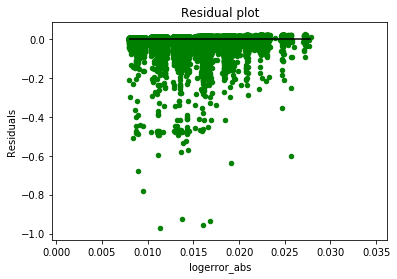

In [72]:
adalib = reload(adalib)
adalib.linreg_model(ds.X_train, ds.X_test, ds.y_train, ds.y_test)

#### Lasso Linear Model

In [73]:
from sklearn.linear_model import Lasso

In [74]:
def zillow_lasso_regression(ds: adalib.DataSet) -> None:
    lasso = Lasso(random_state=123, selection="random")
    lasso.fit(ds.X_train, ds.y_train)
    
    pred_train = lasso.predict(ds.X_train)
    pred_test = lasso.predict(ds.X_test)
    
    return lasso, pred_train, pred_test

lasso, _, _ = zillow_lasso_regression(ds)
print(f"TRAIN: {lasso.score(ds.X_train, ds.y_train)}")
print()
print(f"TEST: {lasso.score(ds.X_test, ds.y_test)}")

TRAIN: 0.0

TEST: -1.9083480533588215e-06


**Conclusion**

Really bad R2 value. Not worth it.

#### Polynomial Regression

In [75]:
ds_poly = adalib.DataSet()
ds_poly.df = df.copy()
ds_poly.xcols = ["in_la_county", "taxdelinquencyflag_encode", "age_bin",
        "bedbathcnt_bin", "tax_value_per_sqft", "latlong_cluster"]
ds_poly.ycol = "logerror_abs"

ds_poly.X_train, ds_poly.X_test, ds_poly.y_train, ds_poly.y_test = train_test_split(ds_poly.df[ds_poly.xcols], ds_poly.df[[ds_poly.ycol]], test_size = .30, random_state = 123)

In [76]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

ndegrees = 3
poly_model = Pipeline([('poly', PolynomialFeatures(degree=ndegrees)),
                   ('linear', LinearRegression(fit_intercept=False))])
# fit to an order-2 polynomial data
poly_model = poly_model.fit(ds_poly.X_train, ds_poly.y_train)
print(f"Coefficients: {poly_model.named_steps['linear'].coef_}")
print()
print(f"TRAIN: R2 = {poly_model.score(ds_poly.X_train, ds_poly.y_train)}")
print(f"TEST: R2 = {poly_model.score(ds_poly.X_test, ds_poly.y_test)}")

Coefficients: [[ 8.59673007e-02  2.48476727e-04 -1.70032372e-02  1.62420016e-03
  -1.62211198e-02 -1.87890474e-04 -1.56046218e-02  2.48441626e-04
   1.72705390e-02  1.06569218e-04  5.30980077e-04 -2.18971946e-06
  -6.83192709e-03 -1.70032368e-02  2.45490128e-03  7.43211970e-03
  -6.73050000e-05  4.52805554e-02  1.71548382e-04  7.52821054e-04
   1.34475748e-05 -4.27284212e-03  2.28542597e-03  3.13878085e-05
   2.88963303e-03  2.69193371e-07 -2.62431609e-05  1.38168288e-02
   2.48441635e-04  1.72705390e-02  1.06569238e-04  5.30980110e-04
  -2.18968376e-06 -6.83192704e-03  1.72705390e-02 -3.30628919e-04
  -2.10149105e-03  1.26265937e-04 -5.12250586e-02 -2.26300878e-04
   1.05207855e-04 -8.94682036e-06  1.08186945e-03 -2.61237550e-04
  -1.86770001e-06  6.19885543e-04  7.60414524e-09  1.75433172e-05
   4.72297693e-03 -1.70032368e-02  2.45490132e-03  7.43211981e-03
  -6.73049965e-05  4.52805554e-02  2.41933469e-05 -4.18509778e-04
  -5.37896020e-06  3.12059578e-04 -1.11870485e-03 -9.33653104e

#### Random Forest Regressor

In [77]:
ds_rf_regr = adalib.DataSet()
ds_rf_regr.df = df.copy()

ds_rf_regr.xcols = [

 'bathroomcnt',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedfinishedsquarefeet',

 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'pooltypeid7',
    
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'roomcnt',
 'unitcnt',
 'yearbuilt',
 'taxvaluedollarcnt',
 'assessmentyear',
 'landtaxvaluedollarcnt',
 'taxamount',
 'taxdelinquencyflag_encode',
# 'bedroomcnt_bin',
# 'bathroomcnt_bin',
 'latlong_cluster',
 'in_la_county',
 'bedbathcnt',
 'bedbathcnt_bin',
 'tax_value_per_sqft',
 'taxdelinquencyflag_encode',
 'age',
 'age_bin']
ds_rf_regr.ycol = "logerror_abs"

ds_rf_regr.X_train, ds_rf_regr.X_test, ds_rf_regr.y_train, ds_rf_regr.y_test = train_test_split(ds_rf_regr.df[ds_rf_regr.xcols], ds_rf_regr.df[[ds_rf_regr.ycol]], test_size = .30, random_state = 123)


In [78]:
from sklearn.ensemble import RandomForestRegressor

In [79]:
ds_rf_regr.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154829 entries, 0 to 167887
Data columns (total 44 columns):
Unnamed: 0                      154829 non-null int64
parcelid                        154829 non-null int64
bathroomcnt                     154829 non-null float64
bedroomcnt                      154829 non-null float64
buildingqualitytypeid           154829 non-null float64
calculatedfinishedsquarefeet    154829 non-null float64
fips                            154829 non-null category
latitude                        154829 non-null float64
longitude                       154829 non-null float64
lotsizesquarefeet               154829 non-null float64
poolcnt                         154829 non-null float64
pooltypeid7                     154829 non-null float64
propertycountylandusecode       154829 non-null object
propertyzoningdesc              154829 non-null object
rawcensustractandblock          154829 non-null category
regionidcity                    154829 non-null float

In [80]:
rf_regr_model = RandomForestRegressor(random_state=123,
                              n_estimators=25, max_depth=10, min_samples_leaf=1000, n_jobs=3)

rf_regr_model.fit(ds_rf_regr.X_train, ds_rf_regr.y_train)

print(list(zip(ds_rf_regr.xcols, rf_regr_model.feature_importances_)))
print()
print(f"TRAIN: R2 = {rf_regr_model.score(ds_rf_regr.X_train, ds_rf_regr.y_train)}")
print(f"TEST: R2 = {rf_regr_model.score(ds_rf_regr.X_test, ds_rf_regr.y_test)}")

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


[('bathroomcnt', 0.002054924612396221), ('bedroomcnt', 0.004027783081748008), ('buildingqualitytypeid', 0.0003214526661531648), ('calculatedfinishedsquarefeet', 0.03459274450590967), ('latitude', 0.03217339370853666), ('longitude', 0.020939302464512134), ('lotsizesquarefeet', 0.08222401928323012), ('poolcnt', 0.00012386218499607946), ('pooltypeid7', 0.0), ('regionidcity', 0.007042674340888428), ('regionidcounty', 0.0002942730129314463), ('regionidzip', 0.08292230754410329), ('roomcnt', 0.00080029102909954), ('unitcnt', 0.0), ('yearbuilt', 0.039075149914445134), ('taxvaluedollarcnt', 0.16139250736213998), ('assessmentyear', 8.696464412097012e-05), ('landtaxvaluedollarcnt', 0.01664278434871753), ('taxamount', 0.02374209946800426), ('taxdelinquencyflag_encode', 0.0), ('latlong_cluster', 0.0034616485491129815), ('in_la_county', 0.0), ('bedbathcnt', 0.0020390433069705223), ('bedbathcnt_bin', 0.0012789245392516163), ('tax_value_per_sqft', 0.07622230518119813), ('taxdelinquencyflag_encode', 0

### Summarize Conclusions